# Desarrollo de una estrategia sencilla para PyRatPack

## Preparación de las herramientas y datos

In [1]:
%load_ext watermark
%watermark

2018-11-02T14:12:19+01:00

CPython 3.6.3
IPython 6.2.1

compiler   : GCC 7.2.0
system     : Linux
release    : 4.8.0-53-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


Comenzamos importando los modulos que vamos a usar. En este caso usaremos **pandas** y **matplotlib**.
Tambien importaremos como si de un módulo se tratara el archivo **pyratpack_tools.py** que habremos guardado en el mismo directorio que este notebook.

In [2]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# plt.rcParams['figure.figsize']=20,10

import pyratpack_tools as tools


In [16]:
# plt.rcParams['figure.figsize']=20,10

from importlib import reload

reload(tools)   #eliminar est celda

<module 'pyratpack_tools' from '/home/argante/anaconda2/Proyectos 7/PyRatPack/pyratpack_tools.py'>

Vamos a cargar los datos de las cotizaciones de los activos que vamos a usar en la cartera. El archivo **data_sistemas.pkl** debera estar en el mismo directorio que este notebook, de lo contrario deberemos añadirle el path hasta el archivo.

Se trata de un archivo pickle de Python, por lo que no solo cargaremos los datos, tambien la estructura del dataframe de pandas que los contiene.

In [6]:
data = pd.read_pickle('data_sistemas.pkl')

Definimos un periodo qu usaremos para tomar una ventana de desplazamiento el que calcularemos la media y la desviación  tipica.

---


## Desarrollo de la estrategia

In [7]:
period = 30
media = data.Close.pct_change().rolling(period).mean()
std = data.Close.pct_change().rolling(period).std()

Para este ejemplo vamos a considerar que los rendimientos del activo libre de riesgo es cero, por simplificar, de modo que el valor del ratio de Sharpe diario será la división de la media entre la desviación típica.

De los sharpe calculados solo tomamos aquellos positivos, pasando a cero el valor de los negativos.

In [8]:
sharpe = media / std
sharpe_positivo = sharpe.dropna().where(sharpe>0,0)

Vamos a calcular los pesos de forma que se reparta todo el capital en cada rebalanceo entre los activos que tengan Sharpe positivo, y lo hará de forma proporcional es decir invirtiendo mas en aquellos con Sharpe mas alto.

Para ello basta con usar la función **get_weekly_returns** de *pyratpack_tools*. A esta función le pasamos data y los valores de Sharpe positivo que hemos calculado. Usamos *dropna=True* para descartar los periodos en los que no hay datos de todos los activos.

Esta función nos devuelve los pesos normalizados calculados a partir de los valores de los Sharpe, y los retornos semanales en base a esos pesos según el rebalanceo de PyRatPack. 

Ademas por defecto grafica la equity de la estrategía contra el benchmark (que se calcula como una cartera equidistribuida de buy and hold), así el drawdown de ambas y por úlimo la evolción de cada uno de los activos según los pesos.

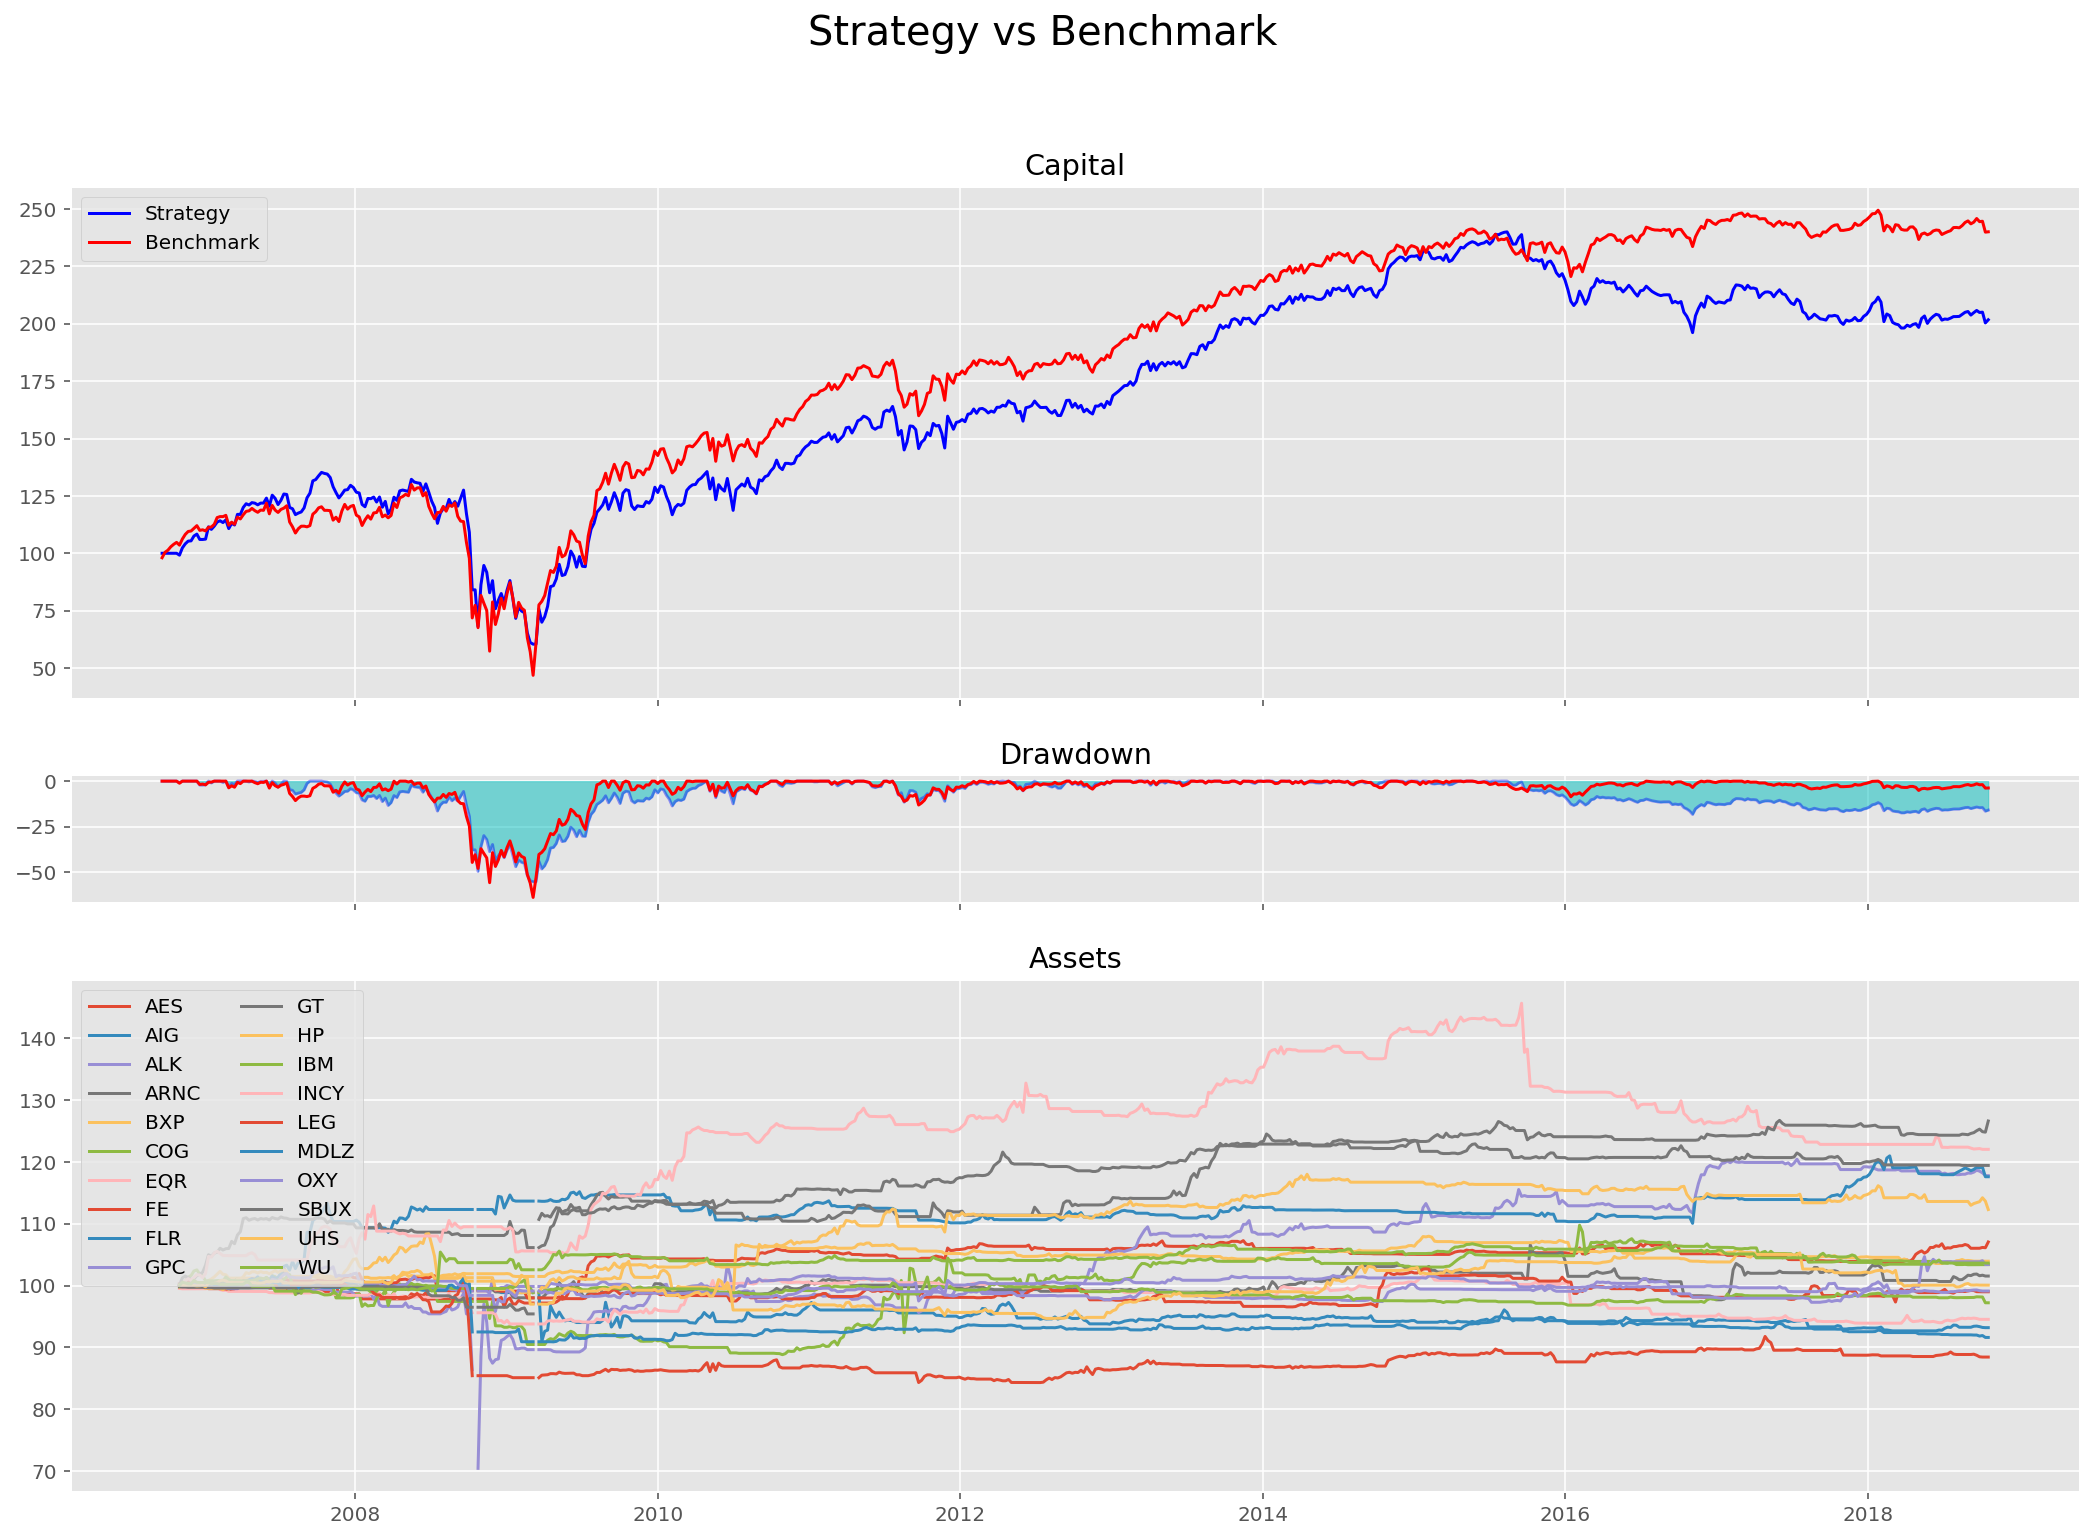

In [9]:
weights, returns = tools.get_weekly_returns(data, sharpe_positivo, dropna=True)

Podemos verificar que los pesos usados son correctos (positivos y suma por fecha entre cero y uno) usando la función **check_weights** de *pyratpack_tools*.

In [10]:
tools.check_weights(weights)

Comprobación Ok. Pesos aceptables.


Otra función util de las herramientas es **return_distribution**, donde podemos ver tanto númerica como gráficamente la aportación de cada activo al resultado final.

In [11]:
tools.return_distribution(returns)

,Retorno
ALK,76.281
INCY,34.2641
SBUX,25.976
HP,24.0261
GT,20.204
COG,16.4042
FLR,7.68138
EQR,6.15063
ARNC,5.33209
IBM,5.03806


Tambien podemos usarla para ver el peso global asignado a cada activo.

In [12]:
tools.return_distribution(weights)

,Retorno
ALK,5198.36
INCY,3932.12
COG,3777
SBUX,3713.97
HP,3459.68
UHS,3392.35
FE,3317.39
FLR,3174.49
IBM,3152.58
LEG,3086.22


La función **retun_blocks** nos muestra lo mismo de manera aún mas gráfica.

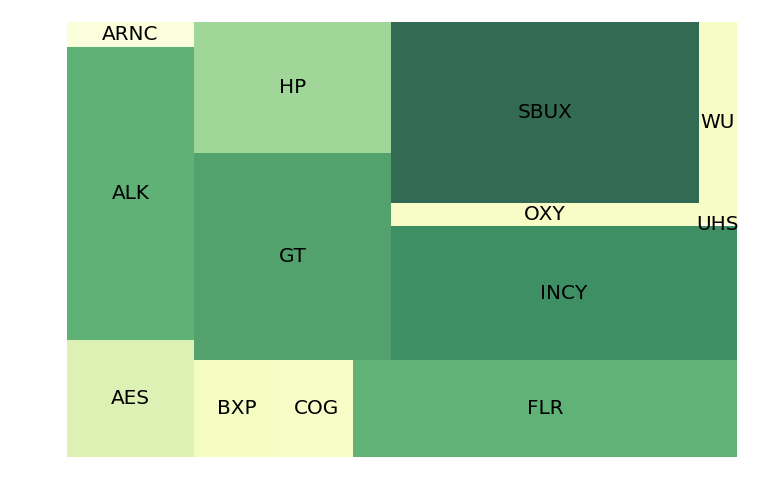

In [10]:
tools.return_blocks(returns)

---

## Optimización de la estrategia

Para realizar la optimización de la estrategia vamos a definirla como una función, donde los parametros de entrada son los datos de cotización diario y el periodo de la ventana rodante. Devolviendo los retornos calculados para esos parametros.

In [15]:
def sharpe_strategy (data, period = 30):
    
    media = data.Close.pct_change().rolling(period).mean()
    std = data.Close.pct_change().rolling(period).std()
    sharpe = media / std
    peso = sharpe.dropna().where(sharpe>0,0)
    weights, returns = tools.get_weekly_returns(data, peso, dropna=True, plot=False)
    
    return returns
    

Para realizar los calculos de la estrategia con un rango de periodos vamos a definir primero dicho rango, y usaremos la función **optimize** de *pyratpack_tools* para realizar el trabajo, pasando como parametros los datos de cotización originales, la función que contiene la estrategia y el rango de periodos.

Esta función nos devuelve un dataframe multiindices de pandas con los retornos de la estrategia para cada periodo.

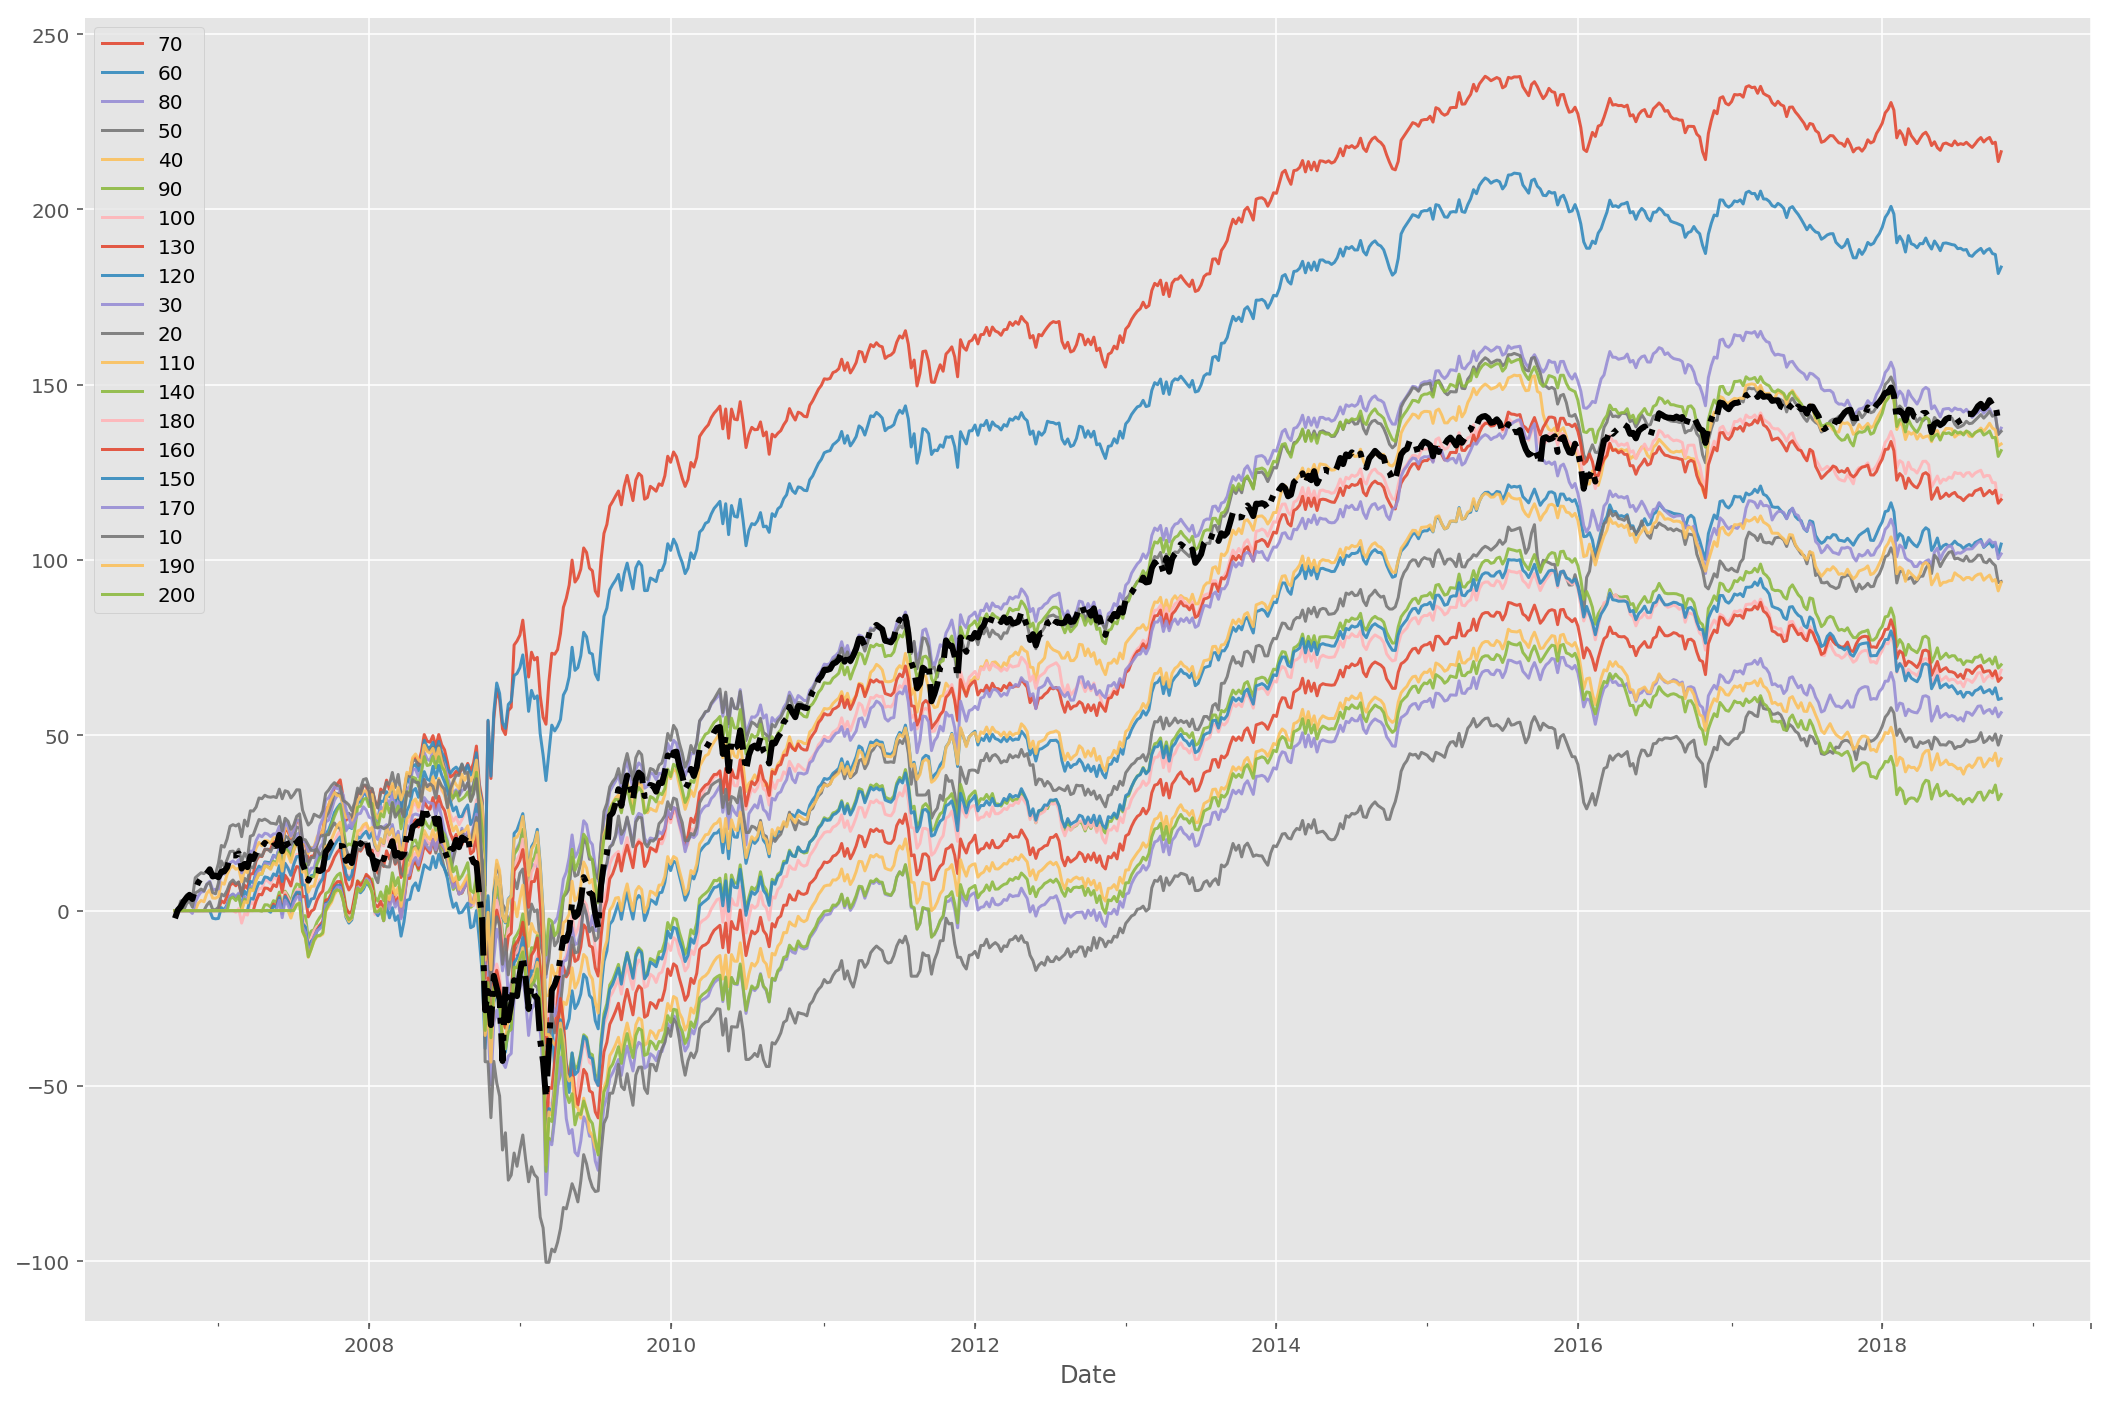

In [38]:
rango=range(10,201,10)
bt_returns = tools.optimize(data, sharpe_strategy, rango)

Por defecto la función nos muestra la gráfica de la equity de la estrategia para cada periodo. En negro punteado se muestra la equity del benchmark. En la leyenda los periodos aparecen ya ordenados de mayor a menor capital final, para facilitar la elección del parametro.

Como vemos entre 40 y 90 parecen estar los mejores resultados, así que usemos de nuevo la función **optimize** para una granulidad mas fina en ese intervalo.

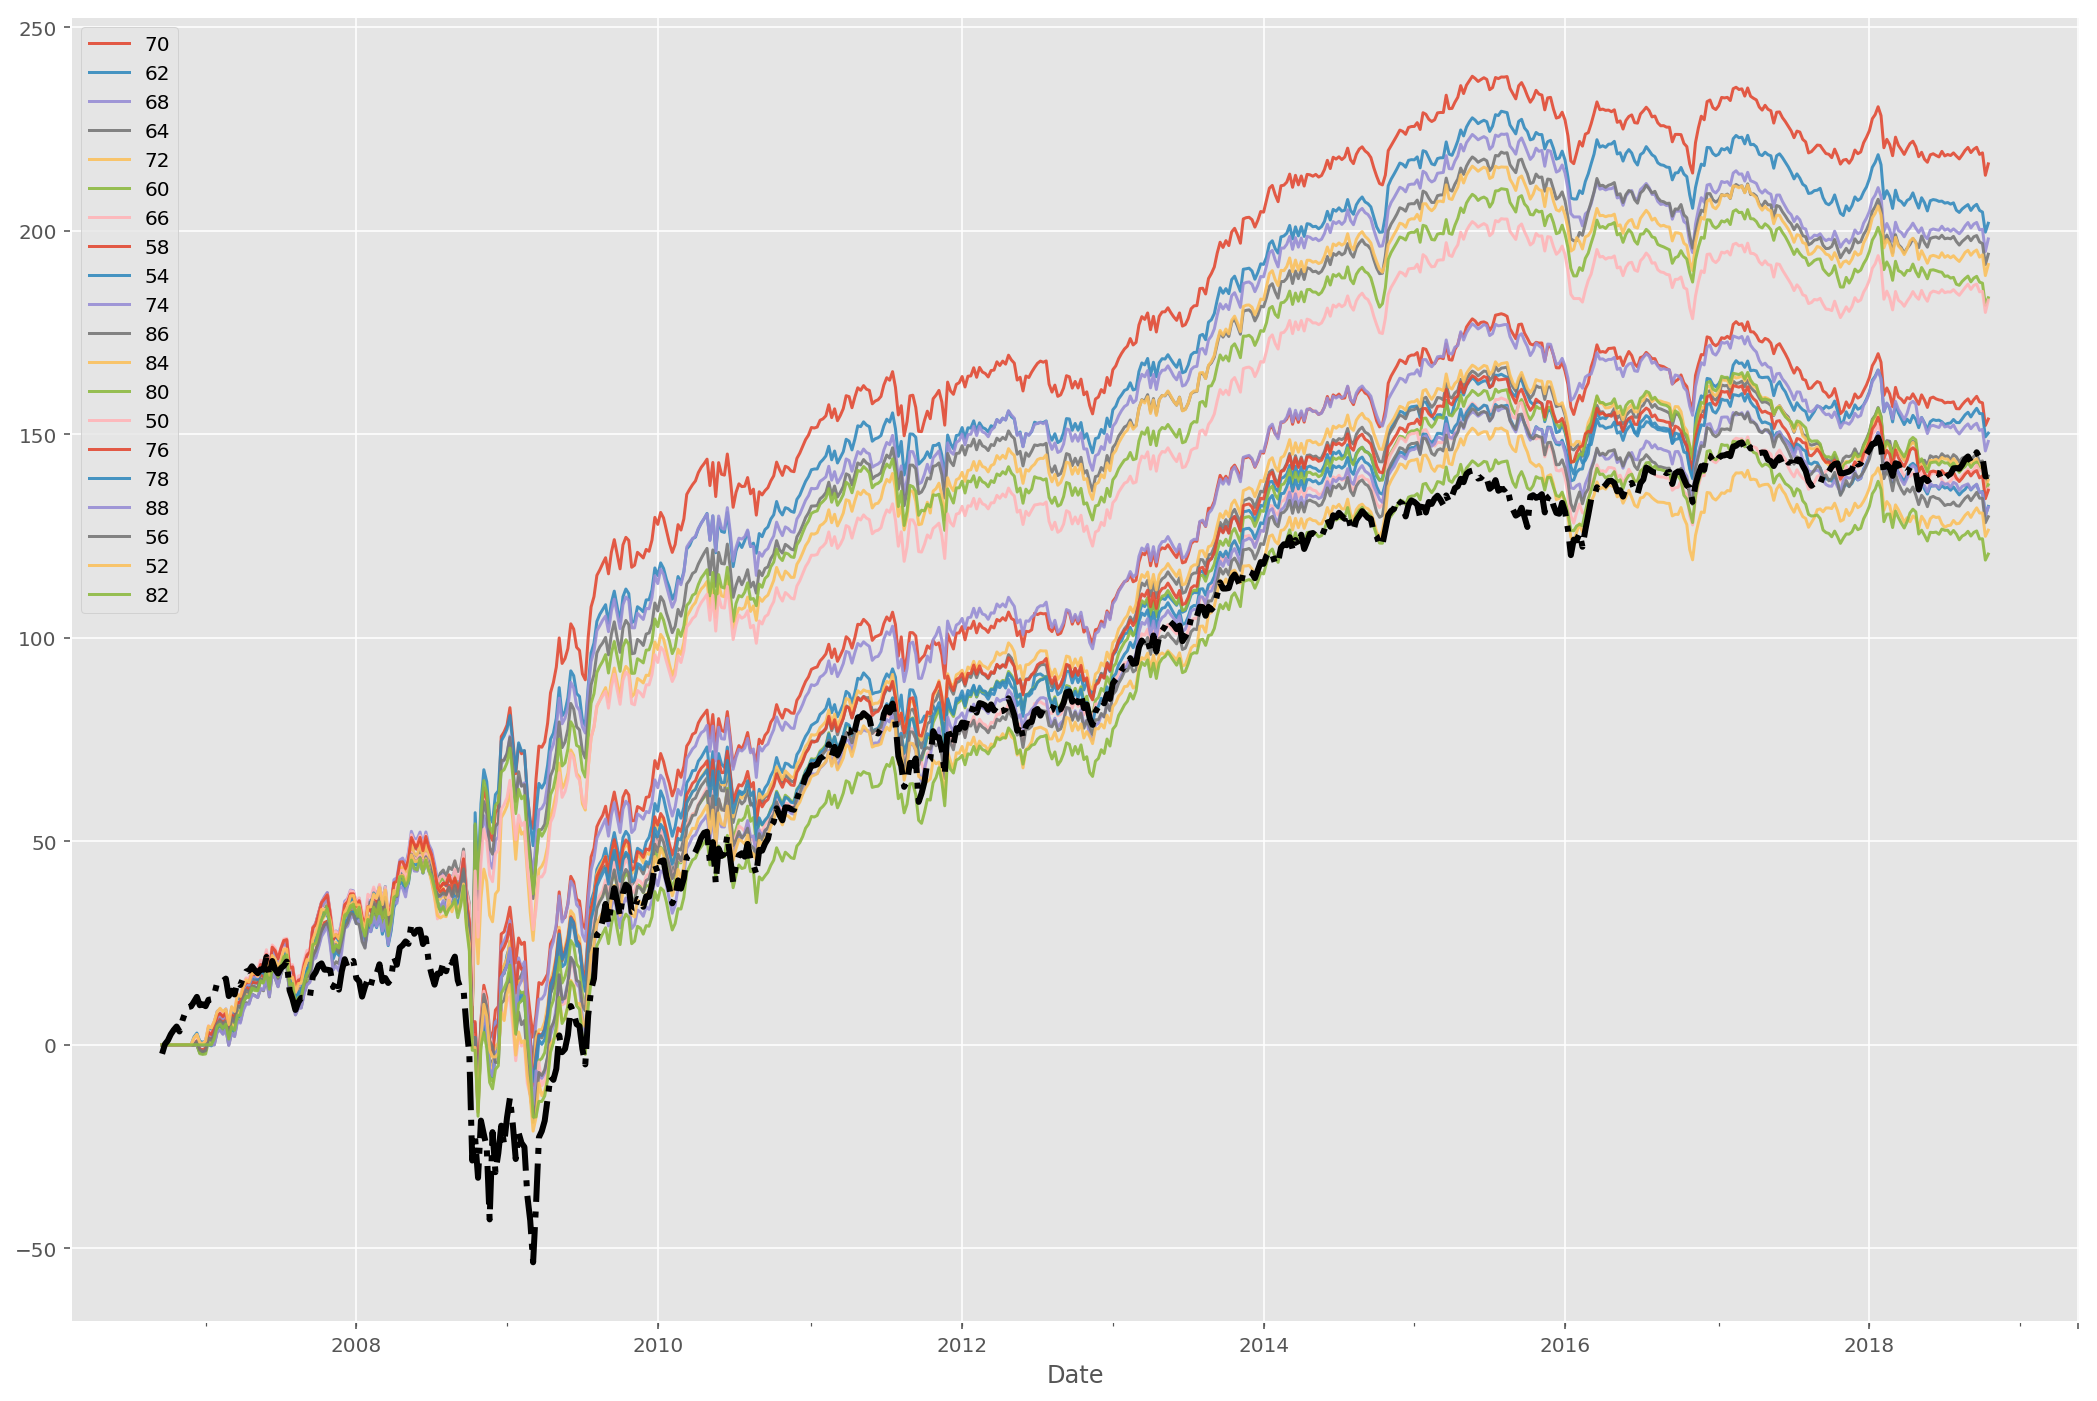

In [18]:
rango=range(50,90,2)
bt_returns = tools.optimize(data, sharpe_strategy, rango)

Tambien podemos usar los retornos devueltos para calcular los indices que nos puedan interesar. Como por ejemplo el Sharpe de la estrategia para cada periodo.

In [20]:
bt_sharpe = bt_returns.sum(axis=1, level=0).mean() / bt_returns.sum(axis=1, level=0).std()
bt_sharpe.sort_values(ascending=False)

70    0.092796
72    0.090152
68    0.088931
64    0.087151
62    0.086899
66    0.085971
60    0.079638
58    0.076335
74    0.074288
54    0.074284
50    0.069441
86    0.069402
84    0.068409
80    0.067944
76    0.067786
78    0.066356
56    0.064893
52    0.063903
88    0.063698
82    0.060245
dtype: float64

Vemos que el periodo que mejor resultado parece dar es el de 70 barras, aunque con un Sharpe de casi cero.

Tambien podemos calcular y graficar el drawdown de las simulaciones.

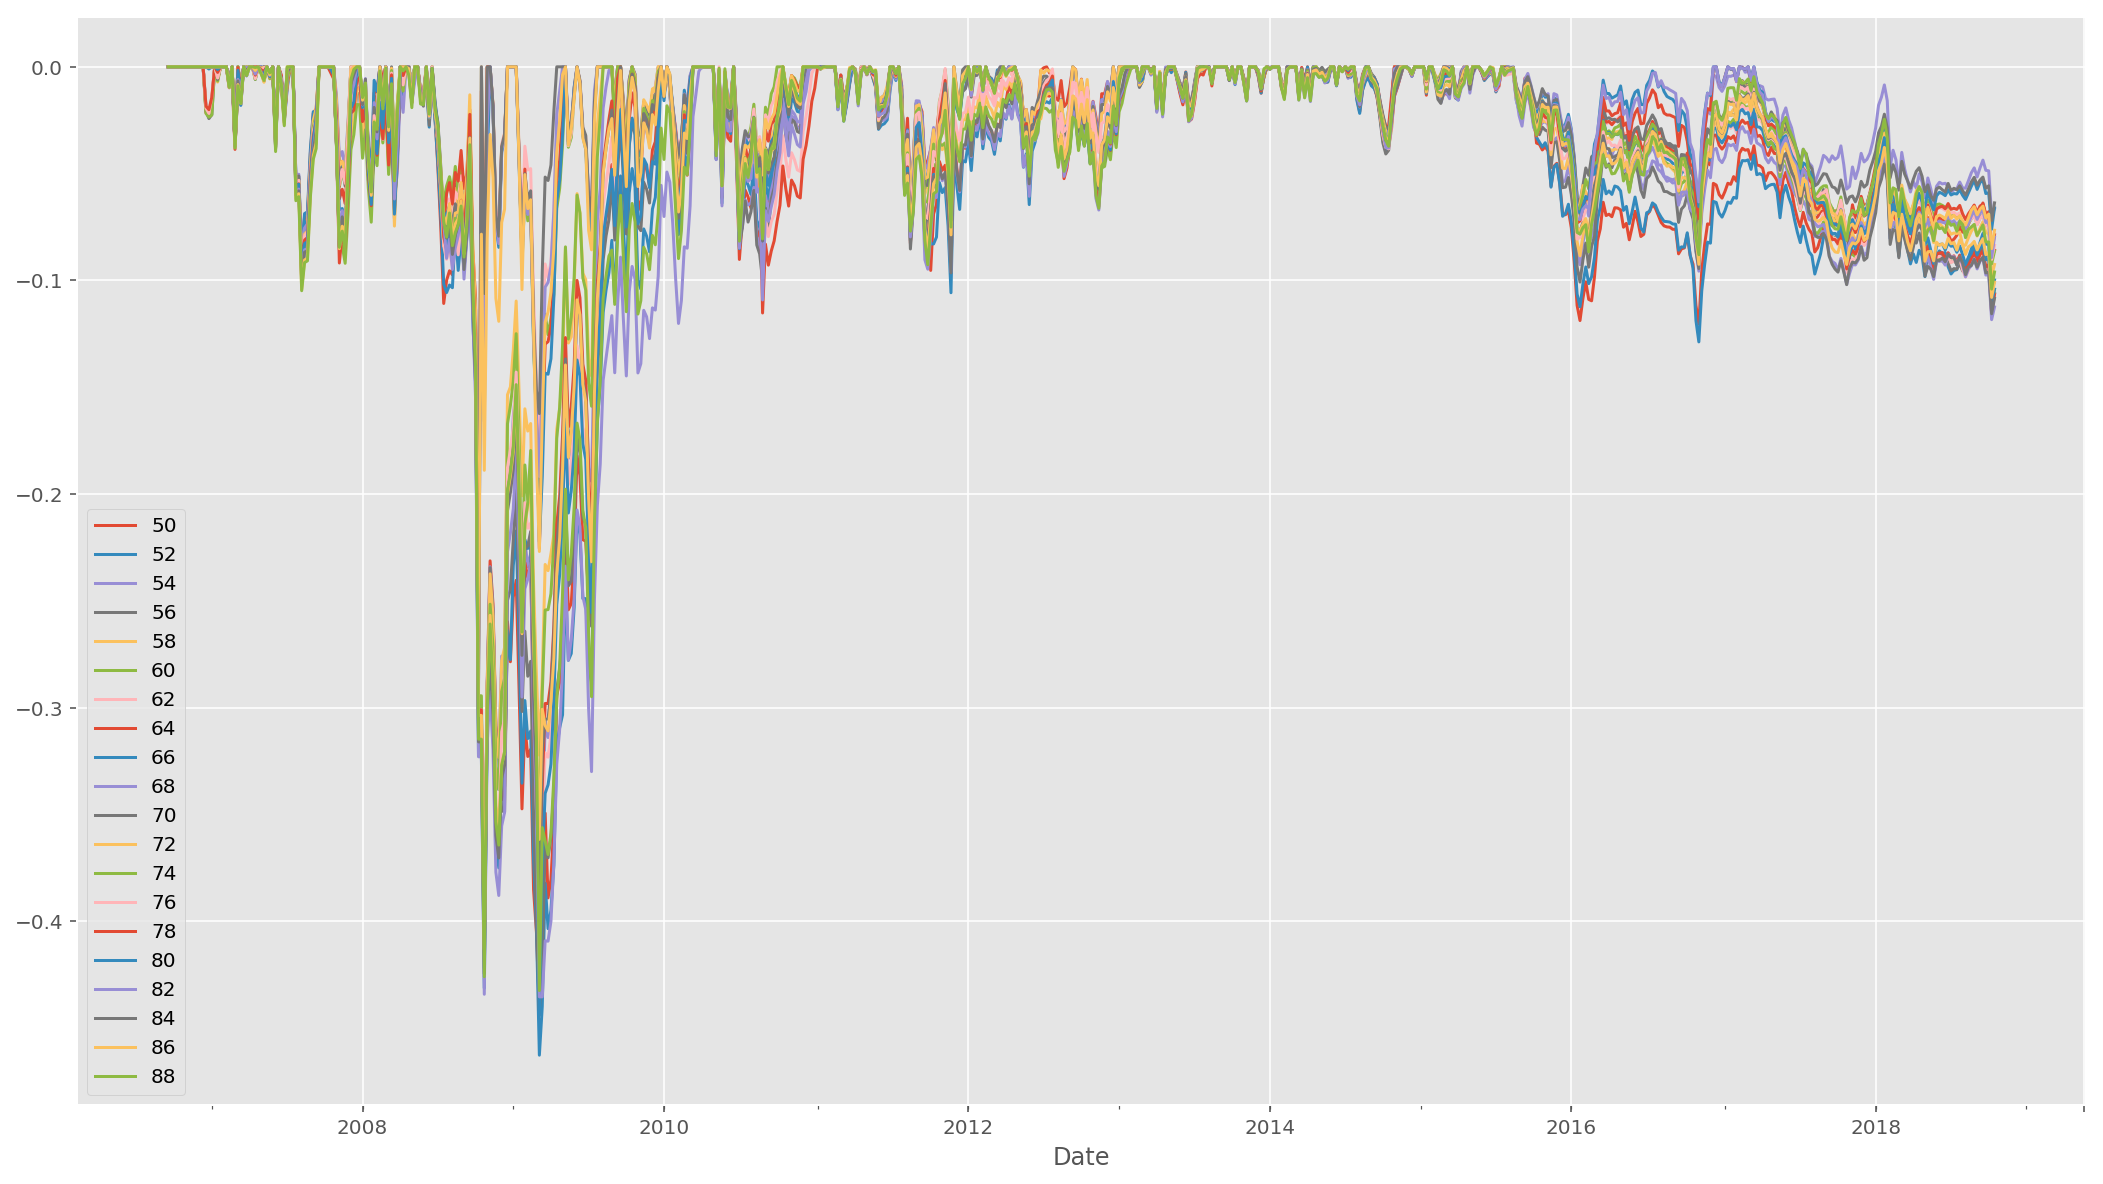

In [28]:
equities = bt_returns.sum(axis=1, level=0).cumsum() + 1
bt_dd = (equities - equities.cummax())  / equities.cummax()

bt_dd.plot(figsize=(18,10))

In [31]:
max_DD = bt_dd.min()
max_DD.sort_values(ascending=False)

64   -0.272634
72   -0.274579
66   -0.276152
70   -0.286583
62   -0.287480
60   -0.289363
68   -0.293666
74   -0.403931
76   -0.408385
78   -0.412288
86   -0.413139
58   -0.414130
54   -0.416111
84   -0.424585
88   -0.432493
82   -0.435432
56   -0.441735
50   -0.443948
80   -0.444135
52   -0.462734
dtype: float64

---

## Preparación de la estrategía para incluirla en la plantilla de PyRatPack

Una vez que tengamos definida y optimizada nuestra estrategia podemos resumirla y prepararla para incluirla en la plantilla de sistemas de PyRatpack, este archivo será el que finalmente se envirá para su inclusión en el proyecto y el que utilizará el meta-sistema cada semana para calcular los pesos de nuestro sistema.



In [32]:
period = 70
media = data.Close.pct_change().rolling(period).mean()
std = data.Close.pct_change().rolling(period).std()
sharpe = media / std
peso = sharpe.dropna().where(sharpe>0,0)

weights, returns = tools.get_weekly_returns(data, peso, dropna=True, plot=False)

La función de nuestro sistema solo devolverá al meta, el último peso calculado.

In [35]:
weights.iloc[-1]

AES     0.163218
AIG     0.000000
ALK     0.038900
ARNC    0.169931
BXP     0.000000
COG     0.008249
EQR     0.000000
FE      0.099044
FLR     0.000000
GPC     0.134297
GT      0.000000
HP      0.020490
IBM     0.000000
INCY    0.000000
LEG     0.000000
MDLZ    0.000000
OXY     0.000000
SBUX    0.240082
UHS     0.125789
WU      0.000000
Name: 2018-10-19 00:00:00, dtype: float64

In [36]:
tools.check_weights(weights)

Comprobación Ok. Pesos aceptables.


---